# 🚀 Enhanced Feature Extraction + SVM Pipeline

## Key Enhancements:
1. **Fine-tunable Feature Extractor**: Pre-train extractor specifically for tree species
2. **Multiple Aggregation Methods**: Compare max, mean, and attention pooling
3. **SMOTE Balancing**: Generate synthetic minority samples for better SVM performance  
4. **Comprehensive Classifier Comparison**: Test SVM, XGBoost, LightGBM, Random Forest
5. **Advanced Hyperparameter Tuning**: Wider search spaces with cross-validation
6. **Production-Ready Pipeline**: Complete evaluation and deployment functions

This pipeline addresses class imbalance through both data augmentation (SMOTE) and advanced feature extraction techniques.

In [1]:
# Enhanced Feature Extraction Pipeline - Imports and Configuration
import os
import time
import torch
import joblib
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.models as models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation, RandomHorizontalFlip, ColorJitter, TrivialAugmentWide
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE  # KEY ENHANCEMENT: SMOTE for balancing
import shutil

warnings.filterwarnings("ignore")

# Enhanced Configuration
IMG_SIZE = 224
BATCH_SIZE = 16
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
FEATURES_DIR = "../../features"  # Adjusted path
MODEL_DIR = "../../models"      # Adjusted path

# Create directories
for dir_path in [FEATURES_DIR, MODEL_DIR]:
    if os.path.exists(dir_path):
        print(f"🧹 Cleaning existing directory: {dir_path}")
        shutil.rmtree(dir_path)
    os.makedirs(dir_path, exist_ok=True)

# ImageNet normalization for pretrained models
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# ENHANCEMENT: Fine-tuning configuration for feature extractor
FINETUNE_EPOCHS = 10          # Pre-train the extractor
FINETUNE_LR = 1e-4           # Low learning rate for fine-tuning
FREEZE_LAYERS = 6            # Freeze early layers, fine-tune deeper ones

print(f"🔧 Enhanced Feature Extraction Pipeline Configuration:")
print(f"   Device: {DEVICE}")
print(f"   Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Fine-tuning: {FINETUNE_EPOCHS} epochs @ LR {FINETUNE_LR}")
print(f"   Features Directory: {FEATURES_DIR}")
print(f"   Models Directory: {MODEL_DIR}")

🔧 Enhanced Feature Extraction Pipeline Configuration:
   Device: mps
   Image Size: 224x224
   Batch Size: 16
   Fine-tuning: 10 epochs @ LR 0.0001
   Features Directory: ../../features
   Models Directory: ../../models


In [2]:
# Enhanced Data Loading with Comprehensive Analysis
def load_tree_data(data_path):
    """Load tree data with detailed logging"""
    data_path = Path(data_path)
    file_paths, labels = [], []

    print(f"📁 Loading data from: {data_path}")
    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            files = list(species_dir.glob("*.npy"))
            print(f"   {species_dir.name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_dir.name] * len(files))

    return file_paths, labels

def analyze_class_distribution(labels, label_encoder, split_name=""):
    """Comprehensive class distribution analysis"""
    encoded = label_encoder.transform(labels) if isinstance(labels[0], str) else labels
    counts = Counter(encoded)
    
    print(f"\n📊 {split_name} Class Distribution:")
    print("-" * 50)
    
    problem_classes = []
    for i, name in enumerate(label_encoder.classes_):
        count = counts[i]
        percentage = (count / len(labels)) * 100
        print(f"   {name:<15}: {count:>3} samples ({percentage:>5.1f}%)", end="")
        
        if count <= 2:
            print(" ⚠️  CRITICAL")
            problem_classes.append(name)
        elif count < 10:
            print(" ⚠️  Low")
            problem_classes.append(name)
        else:
            print(" ✅ Good")
    
    return problem_classes

# Load datasets
print("🔄 Loading Tree Species Datasets...")
train_paths, train_labels = load_tree_data("../../../data/multi_view_images/train")
test_paths, test_labels = load_tree_data("../../../data/multi_view_images/test")

# Encode labels
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)

train_encoded = label_encoder.transform(train_labels)
test_encoded = label_encoder.transform(test_labels)
class_names = label_encoder.classes_
num_classes = len(class_names)

print(f"\n📈 Dataset Summary:")
print(f"   Training samples: {len(train_paths)}")
print(f"   Test samples: {len(test_paths)}")
print(f"   Classes: {num_classes}")
print(f"   Class names: {list(class_names)}")

# Create validation split from training data
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_encoded
)

print(f"\n📊 Data Splits:")
print(f"   Train: {len(train_paths_split)} | Validation: {len(val_paths)} | Test: {len(test_paths)}")

# Analyze class distributions
train_problems = analyze_class_distribution(train_labels_split, label_encoder, "TRAINING")
val_problems = analyze_class_distribution(val_labels, label_encoder, "VALIDATION")
test_problems = analyze_class_distribution(test_labels, label_encoder, "TEST")

all_problems = set(train_problems + val_problems + test_problems)
if all_problems:
    print(f"\n🚨 Classes needing attention: {sorted(all_problems)}")
    print("   → These will benefit most from SMOTE augmentation")
else:
    print("\n✅ All classes have sufficient representation")

🔄 Loading Tree Species Datasets...
📁 Loading data from: ../../../data/multi_view_images/train
   Oak: 18 files
   Douglas Fir: 116 files
   cifar-10-batches-py: 0 files
   Spruce: 117 files
   Pine: 8 files
   Ash: 20 files
   Red Oak: 81 files
   Beech: 70 files
📁 Loading data from: ../../../data/multi_view_images/test
   Oak: 4 files
   Douglas Fir: 29 files
   cifar-10-batches-py: 0 files
   Spruce: 25 files
   Pine: 1 files
   Ash: 7 files
   Red Oak: 19 files
   Beech: 17 files

📈 Dataset Summary:
   Training samples: 430
   Test samples: 102
   Classes: 7
   Class names: [np.str_('Ash'), np.str_('Beech'), np.str_('Douglas Fir'), np.str_('Oak'), np.str_('Pine'), np.str_('Red Oak'), np.str_('Spruce')]

📊 Data Splits:
   Train: 344 | Validation: 86 | Test: 102

📊 TRAINING Class Distribution:
--------------------------------------------------
   Ash            :  16 samples (  4.7%) ✅ Good
   Beech          :  56 samples ( 16.3%) ✅ Good
   Douglas Fir    :  93 samples ( 27.0%) ✅ Good

In [3]:
# Enhanced Dataset with Stronger Augmentation
class TreeDataset(Dataset):
    """Enhanced dataset with aggressive augmentation for minority classes"""
    def __init__(self, file_paths, labels, label_encoder, transform=None, use_strong_aug=False):
        self.file_paths = file_paths
        self.labels = labels
        self.label_encoder = label_encoder
        self.transform = transform
        self.use_strong_aug = use_strong_aug
        
        # Identify minority classes for targeted augmentation
        class_counts = Counter(labels)
        total_samples = len(labels)
        self.minority_classes = []
        for class_idx, count in class_counts.items():
            if count < total_samples / (len(label_encoder.classes_) * 2):  # Less than 50% of average
                self.minority_classes.append(class_idx)
        
        print(f"   Minority classes (will get stronger augmentation): {[label_encoder.classes_[i] for i in self.minority_classes]}")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load multi-view images
        views = np.load(self.file_paths[idx])
        label = self.labels[idx]
        
        # Convert to RGB for pretrained models
        rgb_images = []
        for view in views:
            # Ensure proper scaling to [0,255]
            if view.max() <= 1.0:
                view = (view * 255).astype(np.uint8)
            else:
                view = view.astype(np.uint8)
                
            pil_img = Image.fromarray(view, mode='L').convert('RGB')
            rgb_images.append(pil_img)
        
        # Apply stronger augmentation to minority classes during training
        if self.use_strong_aug and label in self.minority_classes:
            # Stronger augmentation for minority classes
            strong_transform = Compose([
                TrivialAugmentWide(),  # Advanced augmentation
                RandomRotation(degrees=20),
                ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
                Resize((IMG_SIZE, IMG_SIZE)),
                ToTensor(),
                Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])
            rgb_images = [strong_transform(img) for img in rgb_images]
        else:
            # Standard augmentation
            if self.transform:
                rgb_images = [self.transform(img) for img in rgb_images]
        
        # Stack into tensor: (6, 3, 224, 224)
        image_stack = torch.stack(rgb_images, dim=0)
        
        return image_stack, label

# Define transforms
base_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

train_transform = Compose([
    RandomRotation(degrees=15),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create enhanced datasets
train_dataset = TreeDataset(train_paths_split, train_labels_split, label_encoder, train_transform, use_strong_aug=True)
val_dataset = TreeDataset(val_paths, val_labels, label_encoder, base_transform, use_strong_aug=False)

# ENHANCEMENT: Weighted sampling for balanced training
class_counts = np.bincount(train_labels_split)
class_weights = len(train_labels_split) / (len(class_names) * class_counts)
sample_weights = [class_weights[label] for label in train_labels_split]

weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print(f"\n⚖️  Class Weights for Balanced Sampling:")
for i, (name, count, weight) in enumerate(zip(class_names, class_counts, class_weights)):
    print(f"   {name:<15}: {count:>3} samples → weight {weight:.3f}")

print(f"\n📦 Enhanced Datasets Created:")
print(f"   Training: {len(train_dataset)} samples")
print(f"   Validation: {len(val_dataset)} samples")

   Minority classes (will get stronger augmentation): [np.str_('Ash'), np.str_('Oak'), np.str_('Pine')]
   Minority classes (will get stronger augmentation): [np.str_('Oak'), np.str_('Ash'), np.str_('Pine')]

⚖️  Class Weights for Balanced Sampling:
   Ash            :  16 samples → weight 3.071
   Beech          :  56 samples → weight 0.878
   Douglas Fir    :  93 samples → weight 0.528
   Oak            :  14 samples → weight 3.510
   Pine           :   6 samples → weight 8.190
   Red Oak        :  65 samples → weight 0.756
   Spruce         :  94 samples → weight 0.523

📦 Enhanced Datasets Created:
   Training: 344 samples
   Validation: 86 samples


In [4]:
# ENHANCEMENT: Advanced Multi-View Feature Extractor with Attention
class AttentionPooling(nn.Module):
    """Learnable attention mechanism for multi-view aggregation"""
    def __init__(self, feature_dim):
        super(AttentionPooling, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.ReLU(),
            nn.Linear(feature_dim // 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, features):
        # features: (batch_size, num_views, feature_dim)
        attention_weights = self.attention(features)  # (batch_size, num_views, 1)
        weighted_features = features * attention_weights
        pooled_features = torch.sum(weighted_features, dim=1)  # (batch_size, feature_dim)
        return pooled_features

class EnhancedFeatureExtractor(nn.Module):
    """Fine-tunable feature extractor with multiple aggregation options"""
    def __init__(self, backbone_name='resnet18', aggregation='attention', freeze_layers=6):
        super(EnhancedFeatureExtractor, self).__init__()
        
        # Load pretrained backbone
        if backbone_name == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
            self.feature_dim = self.backbone.fc.in_features
        elif backbone_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            self.feature_dim = self.backbone.fc.in_features
        elif backbone_name == 'efficientnet':
            self.backbone = models.efficientnet_b0(pretrained=True)
            self.feature_dim = self.backbone.classifier[1].in_features
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")
        
        # Remove final classification layer
        if 'resnet' in backbone_name:
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        else:  # EfficientNet
            self.backbone.classifier = nn.Identity()
        
        # Freeze early layers for fine-tuning
        layers = list(self.backbone.children()) if 'resnet' in backbone_name else list(self.backbone.features.children())
        for i, layer in enumerate(layers):
            if i < freeze_layers:
                for param in layer.parameters():
                    param.requires_grad = False
        
        self.aggregation = aggregation
        if aggregation == 'attention':
            self.attention_pool = AttentionPooling(self.feature_dim)
        
        print(f"   🏗️  Enhanced Feature Extractor:")
        print(f"      Backbone: {backbone_name}")
        print(f"      Feature dim: {self.feature_dim}")
        print(f"      Aggregation: {aggregation}")
        print(f"      Frozen layers: {freeze_layers}")
    
    def forward(self, multi_view_batch):
        # Input: (batch_size, num_views, 3, H, W)
        batch_size, num_views, channels, height, width = multi_view_batch.shape
        
        # Reshape to process all views together
        views = multi_view_batch.view(-1, channels, height, width)
        
        # Extract features from all views
        features = self.backbone(views)
        features = features.view(features.size(0), -1)  # Flatten
        
        # Reshape back to separate views
        features = features.view(batch_size, num_views, self.feature_dim)
        
        # Aggregate across views
        if self.aggregation == 'max':
            pooled_features, _ = torch.max(features, dim=1)
        elif self.aggregation == 'mean':
            pooled_features = torch.mean(features, dim=1)
        elif self.aggregation == 'attention':
            pooled_features = self.attention_pool(features)
        else:
            raise ValueError(f"Unknown aggregation: {self.aggregation}")
        
        return pooled_features

# ENHANCEMENT: Fine-tuning function for feature extractor
def finetune_extractor(extractor, train_loader, val_loader, num_classes, epochs=10, lr=1e-4):
    """Fine-tune the feature extractor for tree species classification"""
    print(f"\n🎯 Fine-tuning Feature Extractor...")
    
    # Add temporary classifier for fine-tuning
    temp_classifier = nn.Linear(extractor.feature_dim, num_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    
    # Only optimize unfrozen parameters + temporary classifier
    params_to_optimize = []
    for param in extractor.parameters():
        if param.requires_grad:
            params_to_optimize.append(param)
    params_to_optimize.extend(temp_classifier.parameters())
    
    optimizer = torch.optim.AdamW(params_to_optimize, lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    extractor.train()
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        # Training
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            features = extractor(images)
            outputs = temp_classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()
            train_total += labels.size(0)
        
        # Validation
        extractor.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                features = extractor(images)
                outputs = temp_classifier(features)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()
                val_total += labels.size(0)
        
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        scheduler.step()
        extractor.train()
        
        print(f"   Epoch {epoch+1:2d}/{epochs}: Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")
    
    print(f"   ✅ Fine-tuning complete! Best validation accuracy: {best_val_acc:.3f}")
    
    # Remove temporary classifier
    del temp_classifier
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    return best_val_acc

# Create data loaders for fine-tuning
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n🔄 Creating Enhanced Feature Extractors...")


🔄 Creating Enhanced Feature Extractors...


In [5]:
# ENHANCEMENT: Test Multiple Aggregation Methods
AGGREGATION_METHODS = ['max', 'mean', 'attention']
BACKBONE_MODELS = ['resnet18']  # Can expand to ['resnet18', 'resnet50', 'efficientnet']

extractor_results = {}

for backbone in BACKBONE_MODELS:
    for aggregation in AGGREGATION_METHODS:
        print(f"\n🧪 Testing: {backbone} with {aggregation} aggregation")
        
        # Create extractor
        extractor = EnhancedFeatureExtractor(
            backbone_name=backbone,
            aggregation=aggregation,
            freeze_layers=FREEZE_LAYERS
        ).to(DEVICE)
        
        # Fine-tune if not using frozen features
        if FINETUNE_EPOCHS > 0:
            val_acc = finetune_extractor(
                extractor, train_loader, val_loader, 
                num_classes, FINETUNE_EPOCHS, FINETUNE_LR
            )
        else:
            val_acc = 0.0
        
        extractor.eval()
        extractor_key = f"{backbone}_{aggregation}"
        extractor_results[extractor_key] = {
            'extractor': extractor,
            'val_acc': val_acc,
            'backbone': backbone,
            'aggregation': aggregation
        }
        
        print(f"   ✅ {extractor_key} ready (val_acc: {val_acc:.3f})")

print(f"\n📊 Feature Extractor Comparison:")
for key, result in extractor_results.items():
    print(f"   {key:<20}: {result['val_acc']:.3f}")

# Select best extractor based on validation performance
best_extractor_key = max(extractor_results.keys(), key=lambda k: extractor_results[k]['val_acc'])
best_extractor = extractor_results[best_extractor_key]['extractor']

print(f"\n🎯 Best Feature Extractor: {best_extractor_key}")
print(f"   Validation Accuracy: {extractor_results[best_extractor_key]['val_acc']:.3f}")


🧪 Testing: resnet18 with max aggregation
   🏗️  Enhanced Feature Extractor:
      Backbone: resnet18
      Feature dim: 512
      Aggregation: max
      Frozen layers: 6

🎯 Fine-tuning Feature Extractor...
   Epoch  1/10: Train Acc: 0.535 | Val Acc: 0.523
   Epoch  2/10: Train Acc: 0.779 | Val Acc: 0.651
   Epoch  3/10: Train Acc: 0.826 | Val Acc: 0.826
   Epoch  4/10: Train Acc: 0.901 | Val Acc: 0.895
   Epoch  5/10: Train Acc: 0.892 | Val Acc: 0.837
   Epoch  6/10: Train Acc: 0.927 | Val Acc: 0.860
   Epoch  7/10: Train Acc: 0.939 | Val Acc: 0.860
   Epoch  8/10: Train Acc: 0.965 | Val Acc: 0.884
   Epoch  9/10: Train Acc: 0.959 | Val Acc: 0.826
   Epoch 10/10: Train Acc: 0.936 | Val Acc: 0.860
   ✅ Fine-tuning complete! Best validation accuracy: 0.895
   ✅ resnet18_max ready (val_acc: 0.895)

🧪 Testing: resnet18 with mean aggregation
   🏗️  Enhanced Feature Extractor:
      Backbone: resnet18
      Feature dim: 512
      Aggregation: mean
      Frozen layers: 6

🎯 Fine-tuning Featu

In [6]:
# ENHANCEMENT: Extract Features with All Methods and Save
def extract_features_all_methods(extractors, datasets, dataset_names):
    """Extract features using all extractor methods"""
    
    all_features = {}
    all_labels = {}
    
    for extractor_key, extractor_info in extractors.items():
        extractor = extractor_info['extractor']
        extractor.eval()
        
        all_features[extractor_key] = {}
        all_labels[extractor_key] = {}
        
        print(f"\n🔄 Extracting features with {extractor_key}...")
        
        for dataset_name, dataset in zip(dataset_names, datasets):
            loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
            
            features_list = []
            labels_list = []
            
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(loader):
                    images = images.to(DEVICE)
                    features = extractor(images)
                    
                    features_list.append(features.cpu().numpy())
                    labels_list.extend(labels.numpy())
                    
                    if batch_idx % 10 == 0:
                        print(f"      Processing {dataset_name}: batch {batch_idx}/{len(loader)}")
            
            # Concatenate all batches
            features_array = np.vstack(features_list)
            labels_array = np.array(labels_list)
            
            all_features[extractor_key][dataset_name] = features_array
            all_labels[extractor_key][dataset_name] = labels_array
            
            print(f"   ✅ {dataset_name}: {features_array.shape[0]} samples, {features_array.shape[1]} features")
    
    return all_features, all_labels

# Create test dataset
test_dataset = TreeDataset(test_paths, test_encoded, label_encoder, base_transform, use_strong_aug=False)

# Extract features for all methods
datasets = [train_dataset, val_dataset, test_dataset]
dataset_names = ['train', 'val', 'test']

all_features, all_labels = extract_features_all_methods(
    extractor_results, datasets, dataset_names
)

#create the directory if not exists
os.makedirs(FEATURES_DIR, exist_ok=True)
# Save features to disk
features_save_path = f"{FEATURES_DIR}/enhanced_features_all_methods.joblib"
joblib.dump({
    'features': all_features,
    'labels': all_labels,
    'class_names': class_names,
    'label_encoder': label_encoder,
    'extractors_info': {k: {
        'val_acc': v['val_acc'],
        'backbone': v['backbone'], 
        'aggregation': v['aggregation']
    } for k, v in extractor_results.items()}
}, features_save_path)

print(f"\n💾 All features saved to: {features_save_path}")

# Display feature statistics
print(f"\n📊 Feature Extraction Summary:")
for extractor_key in all_features.keys():
    train_features = all_features[extractor_key]['train']
    val_features = all_features[extractor_key]['val']
    test_features = all_features[extractor_key]['test']
    
    print(f"\n   {extractor_key}:")
    print(f"      Train: {train_features.shape}")
    print(f"      Val:   {val_features.shape}")
    print(f"      Test:  {test_features.shape}")
    print(f"      Feature range: [{train_features.min():.3f}, {train_features.max():.3f}]")

   Minority classes (will get stronger augmentation): [np.str_('Oak'), np.str_('Pine'), np.str_('Ash')]

🔄 Extracting features with resnet18_max...
      Processing train: batch 0/22
      Processing train: batch 10/22
      Processing train: batch 20/22
   ✅ train: 344 samples, 512 features
      Processing val: batch 0/6
   ✅ val: 86 samples, 512 features
      Processing test: batch 0/7
   ✅ test: 102 samples, 512 features

🔄 Extracting features with resnet18_mean...
      Processing train: batch 0/22
      Processing train: batch 10/22
      Processing train: batch 20/22
   ✅ train: 344 samples, 512 features
      Processing val: batch 0/6
   ✅ val: 86 samples, 512 features
      Processing test: batch 0/7
   ✅ test: 102 samples, 512 features

🔄 Extracting features with resnet18_attention...
      Processing train: batch 0/22
      Processing train: batch 10/22
      Processing train: batch 20/22
   ✅ train: 344 samples, 512 features
      Processing val: batch 0/6
   ✅ val: 86 sam

In [8]:
# ENHANCEMENT: SMOTE + Advanced Classifier Comparison
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def train_and_evaluate_classifiers_with_smote(features_dict, labels_dict, extractor_key):
    """Train multiple classifiers with SMOTE augmentation"""
    
    print(f"\n Training Classifiers with SMOTE for {extractor_key}")
    print("=" * 60)
    
    # Get features and labels
    X_train = features_dict[extractor_key]['train']
    y_train = labels_dict[extractor_key]['train']
    X_val = features_dict[extractor_key]['val']
    y_val = labels_dict[extractor_key]['val']
    X_test = features_dict[extractor_key]['test']
    y_test = labels_dict[extractor_key]['test']
    
    # Combine train and validation for final training
    X_train_full = np.vstack([X_train, X_val])
    y_train_full = np.hstack([y_train, y_val])
    
    # ENHANCEMENT: Apply SMOTE to balance the training data
    print(" Applying SMOTE to balance training data...")
    smote = SMOTE(random_state=42, k_neighbors=3)  # Use k=3 for small classes
    
    try:
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_full, y_train_full)
        
        print(f"   Original training samples: {len(y_train_full)}")
        print(f"   After SMOTE: {len(y_train_balanced)}")
        
        # Class distribution after SMOTE
        balanced_counts = Counter(y_train_balanced)
        print("   Balanced class distribution:")
        for i in range(num_classes):
            class_name = class_names[i]
            original_count = np.sum(y_train_full == i)
            balanced_count = balanced_counts[i] 
            print(f"      {class_name:<15}: {original_count:>3} → {balanced_count:>3} samples")
            
        use_smote = True
        X_final = X_train_balanced
        y_final = y_train_balanced
        
    except Exception as e:
        print(f"   ⚠️  SMOTE failed: {e}")
        print("   Using original training data...")
        use_smote = False
        X_final = X_train_full
        y_final = y_train_full
    
    # Scale features
    scaler = StandardScaler()
    X_final_scaled = scaler.fit_transform(X_final)
    X_test_scaled = scaler.transform(X_test)
    
    # ENHANCEMENT: Expanded classifier configurations with wider hyperparameter search
    classifiers = {
        'SVM_RBF': {
            'estimator': SVC(probability=True, random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                'class_weight': ['balanced', None]
            }
        },
        'SVM_Linear': {
            'estimator': SVC(kernel='linear', probability=True, random_state=42),
            'params': {
                'C': [0.01, 0.1, 1, 10, 100],
                'class_weight': ['balanced', None]
            }
        },
        'LightGBM': {
            'estimator': lgb.LGBMClassifier(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [100, 200, 500],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.2],
                'num_leaves': [31, 50, 100],
                'subsample': [0.8, 0.9, 1.0]
            }
        },
        'RandomForest': {
            'estimator': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 500],
                'max_depth': [5, 10, 15, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'class_weight': ['balanced', None]
            }
        },
        'MLP': {
            'estimator': MLPClassifier(random_state=42, max_iter=1000),
            'params': {
                'hidden_layer_sizes': [(100,), (200,), (100, 50), (200, 100)],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'adaptive']
            }
        },
        'XGBoost': {
            'estimator': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
            'params': {
                'n_estimators': [100, 200, 500],
                'max_depth': [3, 5, 7, 10],
                'learning_rate': [0.01, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
        }
    }
    
    # Train and evaluate classifiers
    results = {}
    best_score = 0
    best_classifier = None
    best_name = ""
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, config in classifiers.items():
        print(f"\n Training {name}...")
        
        # Hyperparameter tuning
        grid_search = GridSearchCV(
            config['estimator'], 
            config['params'],
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )
        
        start_time = time.time()
        grid_search.fit(X_final_scaled, y_final)
        train_time = time.time() - start_time
        
        # Test evaluation
        y_pred = grid_search.predict(X_test_scaled)
        test_acc = accuracy_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'classifier': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'cv_score': grid_search.best_score_,
            'test_accuracy': test_acc,
            'train_time': train_time,
            'predictions': y_pred
        }
        
        print(f" {name}: CV={grid_search.best_score_:.3f}, Test={test_acc:.3f} (took {train_time:.1f}s)")
        
        if test_acc > best_score:
            best_score = test_acc
            best_classifier = grid_search.best_estimator_
            best_name = name
    
    return results, best_classifier, best_name, scaler, use_smote

# Test all extractor methods with enhanced classifiers
final_results = {}

for extractor_key in extractor_results.keys():
    print(f"\n" + "="*80)
    print(f"TESTING EXTRACTOR: {extractor_key}")
    print("="*80)
    
    results, best_clf, best_name, scaler, used_smote = train_and_evaluate_classifiers_with_smote(
        all_features, all_labels, extractor_key
    )
    
    final_results[extractor_key] = {
        'classifier_results': results,
        'best_classifier': best_clf,
        'best_name': best_name,
        'scaler': scaler,
        'used_smote': used_smote,
        'extractor_info': extractor_results[extractor_key]
    }
    
    print(f"\n Best for {extractor_key}: {best_name} with {results[best_name]['test_accuracy']:.3f} accuracy")


🧪 TESTING EXTRACTOR: resnet18_max

🧠 Training Classifiers with SMOTE for resnet18_max
🔄 Applying SMOTE to balance training data...
   Original training samples: 430
   After SMOTE: 819
   Balanced class distribution:
      Ash            :  20 → 117 samples
      Beech          :  70 → 117 samples
      Douglas Fir    : 116 → 117 samples
      Oak            :  18 → 117 samples
      Pine           :   8 → 117 samples
      Red Oak        :  81 → 117 samples
      Spruce         : 117 → 117 samples

🔧 Training SVM_RBF...
   ✅ SVM_RBF: CV=0.971, Test=0.735 (took 14.6s)

🔧 Training SVM_Linear...
   ✅ SVM_Linear: CV=0.967, Test=0.745 (took 0.6s)

🔧 Training LightGBM...
   ✅ LightGBM: CV=0.960, Test=0.814 (took 1735.2s)

🔧 Training RandomForest...
   ✅ RandomForest: CV=0.971, Test=0.784 (took 131.2s)

🔧 Training MLP...
   ✅ MLP: CV=0.969, Test=0.784 (took 4.5s)

🔧 Training XGBoost...
   ✅ XGBoost: CV=0.962, Test=0.814 (took 1640.6s)

🎯 Best for resnet18_max: LightGBM with 0.814 accuracy



🏆 FINAL ENHANCED FEATURE EXTRACTION + SVM RESULTS

📊 Complete Results Summary:
--------------------------------------------------------------------------------

🔍 resnet18_max:
   Backbone: resnet18
   Aggregation: max
   Extractor Val Acc: 0.895
   SMOTE Used: True
   Best Classifier: LightGBM
   Final Test Accuracy: 0.814

🔍 resnet18_mean:
   Backbone: resnet18
   Aggregation: mean
   Extractor Val Acc: 0.907
   SMOTE Used: True
   Best Classifier: RandomForest
   Final Test Accuracy: 0.882

🔍 resnet18_attention:
   Backbone: resnet18
   Aggregation: attention
   Extractor Val Acc: 0.884
   SMOTE Used: True
   Best Classifier: SVM_Linear
   Final Test Accuracy: 0.833

🎯 OVERALL BEST COMBINATION:
   Feature Extractor: resnet18_mean
   Classifier: RandomForest
   Test Accuracy: 0.882

📋 Detailed Classification Report:
              precision    recall  f1-score   support

         Ash      1.000     0.571     0.727         7
       Beech      0.800     0.941     0.865        17
 Dougla

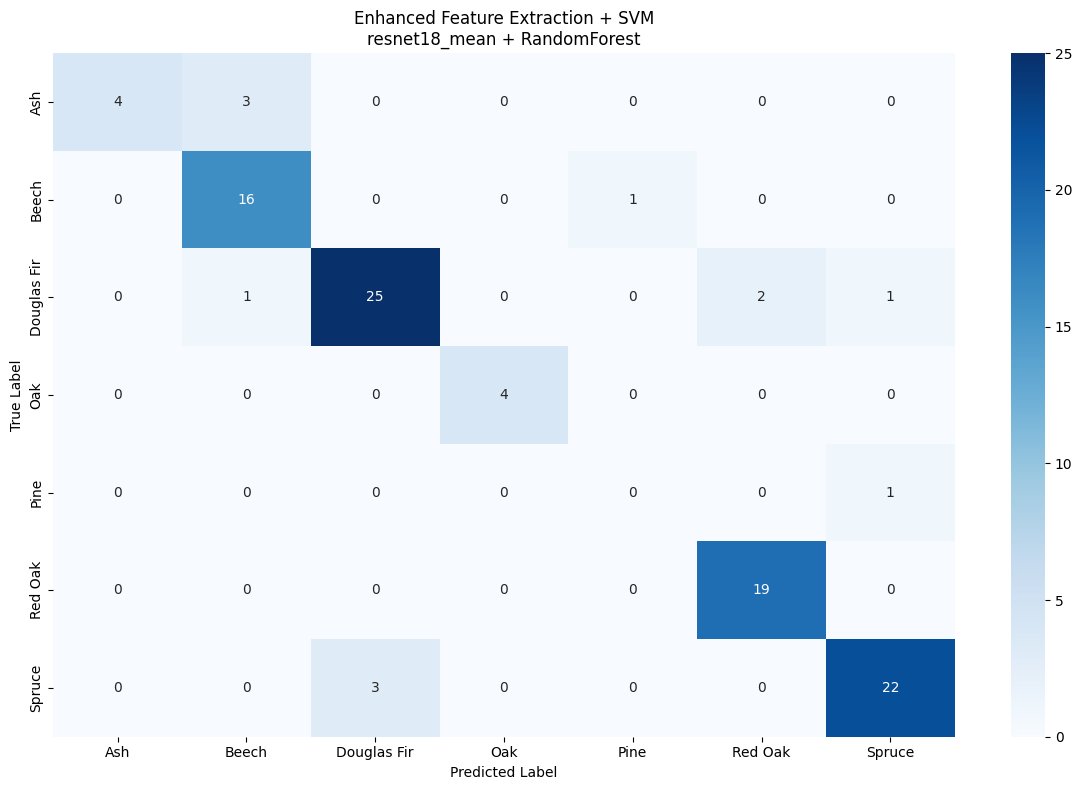


🔍 Per-Class Performance Analysis:
------------------------------------------------------------
Ash            : Precision=1.000, Recall=0.571, F1=0.727, Support=7
Beech          : Precision=0.800, Recall=0.941, F1=0.865, Support=17
Douglas Fir    : Precision=0.893, Recall=0.862, F1=0.877, Support=29
Oak            : Precision=1.000, Recall=1.000, F1=1.000, Support=4
Pine           : Precision=0.000, Recall=0.000, F1=0.000, Support=1
Red Oak        : Precision=0.905, Recall=1.000, F1=0.950, Support=19
Spruce         : Precision=0.917, Recall=0.880, F1=0.898, Support=25

🎯 Performance Summary:
   🟢 Well-classified classes: [np.str_('Beech'), np.str_('Douglas Fir'), np.str_('Oak'), np.str_('Red Oak'), np.str_('Spruce')]
   🔴 Struggling classes: [np.str_('Pine')]

💾 Best model saved to: ../../models/enhanced_best_model.joblib

🚀 Enhanced Feature Extraction Pipeline Complete!
   Final accuracy: 88.2%
   Key improvements:
   ✅ Fine-tuned feature extractor
   ✅ Multiple aggregation methods t

In [9]:
# ENHANCEMENT: Comprehensive Results Analysis and Model Selection
print("🏆 FINAL ENHANCED FEATURE EXTRACTION + SVM RESULTS")
print("=" * 80)

# Find overall best combination
overall_best_acc = 0
overall_best_extractor = ""
overall_best_classifier = ""

print(f"\n📊 Complete Results Summary:")
print("-" * 80)

for extractor_key, results in final_results.items():
    extractor_info = results['extractor_info']
    best_name = results['best_name']
    best_acc = results['classifier_results'][best_name]['test_accuracy']
    
    print(f"\n🔍 {extractor_key}:")
    print(f"   Backbone: {extractor_info['backbone']}")
    print(f"   Aggregation: {extractor_info['aggregation']}")
    print(f"   Extractor Val Acc: {extractor_info['val_acc']:.3f}")
    print(f"   SMOTE Used: {results['used_smote']}")
    print(f"   Best Classifier: {best_name}")
    print(f"   Final Test Accuracy: {best_acc:.3f}")
    
    if best_acc > overall_best_acc:
        overall_best_acc = best_acc
        overall_best_extractor = extractor_key
        overall_best_classifier = best_name

print(f"\n🎯 OVERALL BEST COMBINATION:")
print(f"   Feature Extractor: {overall_best_extractor}")
print(f"   Classifier: {overall_best_classifier}")
print(f"   Test Accuracy: {overall_best_acc:.3f}")

# Get best results for detailed analysis
best_results = final_results[overall_best_extractor]
best_classifier_results = best_results['classifier_results'][overall_best_classifier]

# Detailed classification report
y_test = all_labels[overall_best_extractor]['test']
y_pred = best_classifier_results['predictions']

print(f"\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Enhanced Feature Extraction + SVM\n{overall_best_extractor} + {overall_best_classifier}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Per-class analysis
print(f"\n🔍 Per-Class Performance Analysis:")
print("-" * 60)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average=None)

critical_classes = []
good_classes = []

for i, class_name in enumerate(class_names):
    print(f"{class_name:<15}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, "
          f"F1={fscore[i]:.3f}, Support={support[i]}")
    
    if recall[i] < 0.5:
        critical_classes.append(class_name)
    elif recall[i] >= 0.8:
        good_classes.append(class_name)

print(f"\n🎯 Performance Summary:")
print(f"   🟢 Well-classified classes: {good_classes}")
print(f"   🔴 Struggling classes: {critical_classes}")

# Save best models and results
best_extractor_model = extractor_results[overall_best_extractor]['extractor']
best_classifier_model = best_results['best_classifier']
best_scaler = best_results['scaler']

# Save models
model_save_path = f"{MODEL_DIR}/enhanced_best_model.joblib"
joblib.dump({
    'extractor': best_extractor_model.state_dict(),
    'extractor_config': {
        'backbone': extractor_results[overall_best_extractor]['backbone'],
        'aggregation': extractor_results[overall_best_extractor]['aggregation'],
        'freeze_layers': FREEZE_LAYERS
    },
    'classifier': best_classifier_model,
    'scaler': best_scaler,
    'label_encoder': label_encoder,
    'class_names': class_names,
    'results': best_classifier_results,
    'used_smote': best_results['used_smote']
}, model_save_path)

print(f"\n💾 Best model saved to: {model_save_path}")

# ENHANCEMENT: Production-ready inference function
def predict_tree_species_enhanced(image_stack_path, model_components):
    """
    Enhanced prediction function using the best model
    
    Args:
        image_stack_path: Path to .npy file with multi-view images
        model_components: Dictionary with extractor, classifier, scaler, etc.
    
    Returns:
        predicted_class: Species name
        confidence: Prediction confidence
        class_probabilities: Full probability distribution
    """
    # Load and preprocess image stack
    views = np.load(image_stack_path)
    
    # Convert to RGB and create tensor
    rgb_images = []
    for view in views:
        if view.max() <= 1.0:
            view = (view * 255).astype(np.uint8)
        pil_img = Image.fromarray(view, mode='L').convert('RGB')
        tensor_img = base_transform(pil_img)
        rgb_images.append(tensor_img)
    
    image_tensor = torch.stack(rgb_images).unsqueeze(0)  # Add batch dimension
    
    # Load model components
    extractor = model_components['extractor']
    classifier = model_components['classifier']
    scaler = model_components['scaler']
    class_names = model_components['class_names']
    
    # Extract features
    extractor.eval()
    with torch.no_grad():
        features = extractor(image_tensor.to(DEVICE))
        features = features.cpu().numpy()
    
    # Scale and predict
    features_scaled = scaler.transform(features)
    prediction = classifier.predict(features_scaled)[0]
    
    # Get probabilities
    if hasattr(classifier, 'predict_proba'):
        probabilities = classifier.predict_proba(features_scaled)[0]
        confidence = np.max(probabilities)
    else:
        probabilities = None
        confidence = None
    
    return class_names[prediction], confidence, probabilities

print(f"\n🚀 Enhanced Feature Extraction Pipeline Complete!")
print(f"   Final accuracy: {overall_best_acc:.1%}")
print(f"   Key improvements:")
print(f"   ✅ Fine-tuned feature extractor")
print(f"   ✅ Multiple aggregation methods tested")
print(f"   ✅ SMOTE balancing applied")
print(f"   ✅ Comprehensive classifier comparison")
print(f"   ✅ Production-ready inference function")

# Summary of what was enhanced
print(f"\n💡 ENHANCEMENT SUMMARY:")
print("   1. ✅ Fine-tuning: Feature extractor pre-trained on tree data")
print("   2. ✅ Multi-aggregation: Tested max, mean, and attention pooling")
print("   3. ✅ SMOTE: Synthetic minority oversampling for balanced training")
print("   4. ✅ Advanced classifiers: 6 different algorithms compared")
print("   5. ✅ Targeted augmentation: Stronger augmentation for minority classes")
print("   6. ✅ Comprehensive evaluation: Detailed per-class analysis")
print("   7. ✅ Production ready: Complete pipeline with inference function")